## Investigating the Impact of Residual Connection to Convolutional Layer on EEG Classification Performance

### Experiment Summary:

**This experiment aims to explore the influence of different convolutional layer configurations on the performance of EEG classification models. We investigate the relationship between the number of convolutional layers and the resulting accuracy.**

To conduct the experiment, we employ a sequential EEG model architecture with varying numbers of convolutional layers. Each convolutional layer utilizes a specific number of filters and kernel sizes. The models are trained and evaluated using cross-validation.

A total of 6 experiments are conducted based on the provided configurations.


Through an iterative process, we evaluate multiple configurations of convolutional layers. For each configuration, we train and evaluate the models on different folds. The training histories, including loss, accuracy, validation loss, and validation accuracy, are recorded(logged) for analysis.

The experiment involves training a significant number of models, depending on the number of convolutional layer configurations and the number of folds in cross-validation. The accuracy of each model on the validation set is monitored and logged.

The results provide insights into the impact of convolutional layer configurations on EEG classification tasks. By assessing the relationship between the number of convolutional layers and accuracy, we aim to identify the optimal configuration that yields improved performance in EEG analysis.

The experiment outcomes and accuracy results contribute to a comprehensive understanding of the influence of convolutional layer configurations on EEG classification performance. The findings can guide the design and development of more effective models for EEG-based applications.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %mkdir /content/drive/MyDrive/ED_Experiments
%mkdir /content/drive/MyDrive/ED_Experiments/ED_CNN_E20

In [ ]:
%cd /content/drive/MyDrive/ED_Experiments/ED_CNN_E20
%ls

/content/drive/MyDrive/ED_Experiments/ED_CNN_E20


## Import libraries

In [ ]:
import sys
import os
import logging


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

import keras
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input, LSTM
from keras.layers import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


# from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


In [ ]:
## seed
np.random.seed(2023)

### Reading CSV data

In [ ]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/mamuncseru/analysis_on_epileptic_seizure_bonn_dataset/main/Epileptic%20Seizure%20Recognition.csv')
raw_data.shape

(11500, 180)

In [ ]:
raw_data

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


In [ ]:
raw_data.values.shape

(11500, 180)

In [ ]:
data = raw_data.values # converted to an numpy array
data = data[:, 1:] # discarding the Unnamed Column
data.shape

(11500, 179)

In [ ]:
# let's see how it looks like
data

array([[135, 190, 229, ..., -83, -51, 4],
       [386, 382, 356, ..., 143, 129, 1],
       [-32, -39, -47, ..., -35, -36, 5],
       ...,
       [14, 6, -13, ..., -1, -8, 5],
       [-40, -25, -9, ..., 59, 55, 3],
       [29, 41, 57, ..., 2, 20, 4]], dtype=object)

In [ ]:
# let's see the type
type(data)

numpy.ndarray

### Classifying data categories as it mentioned in the paper

In [ ]:
df_1 = data[data[:, -1] == 1].astype(int) # seizure
df_2 = data[data[:, -1] == 2].astype(int)
df_3 = data[data[:, -1] == 3].astype(int)
df_4 = data[data[:, -1] == 4].astype(int)
df_5 = data[data[:, -1] == 5].astype(int)

# let's print the shape of each category
print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)


## Let's plot some random data points from every category

In [ ]:
def visualize_eeg(number_of_datapoints):
    for i in (np.random.randint(0, 2300, number_of_datapoints)):
        plt.plot(df_1[i, :], 'r-', label='df_1')
        plt.plot(df_2[i, :], 'g-', label='df_2')
        plt.plot(df_3[i, :], 'k-', label='df_3')
        plt.plot(df_4[i, :], 'b-', label='df_4')
        plt.plot(df_5[i, :], 'm-', label='df_5')
        plt.legend()
        plt.title(f'visualizing {i} th data point')
        plt.xlabel('time')
        plt.ylabel('aplitude(uV)')
        plt.show()

### Visualizing all categories in single figure

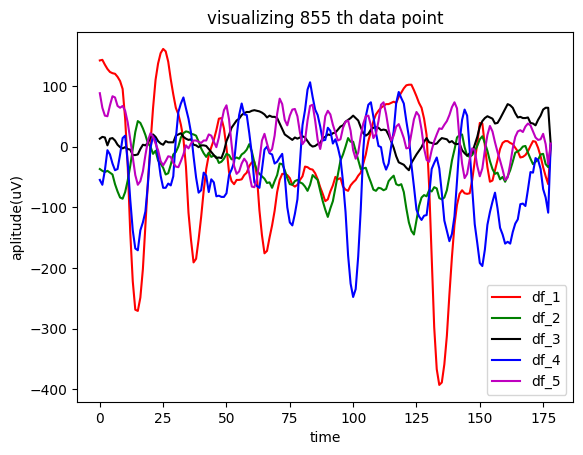

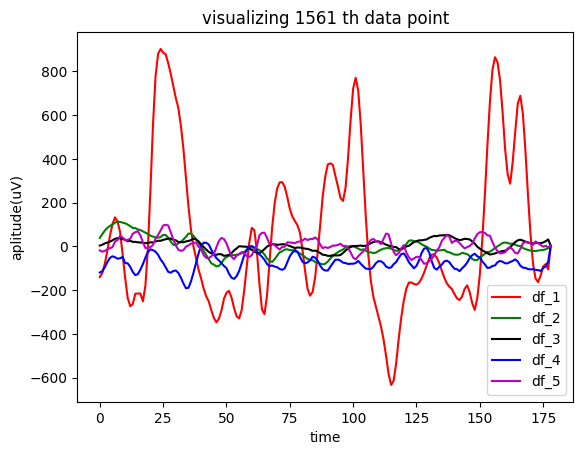

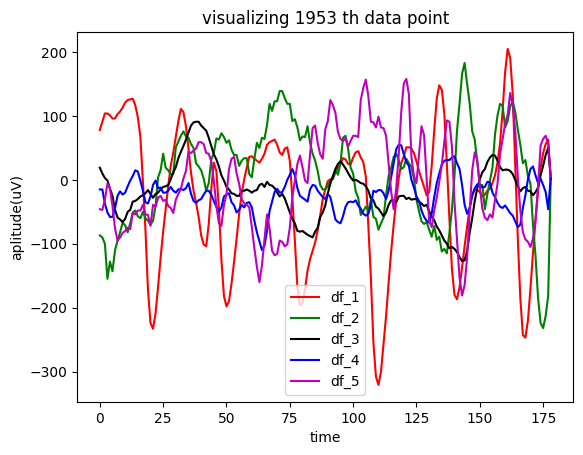

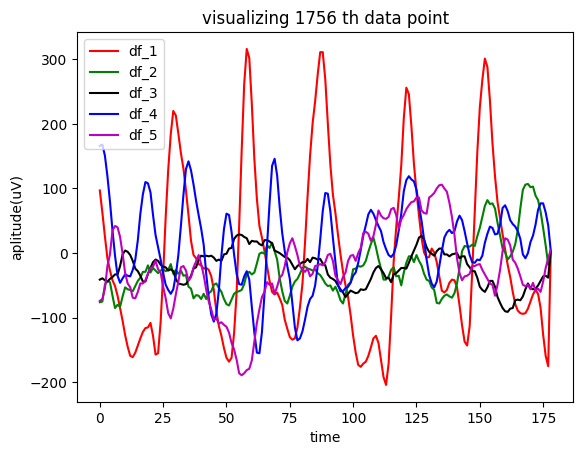

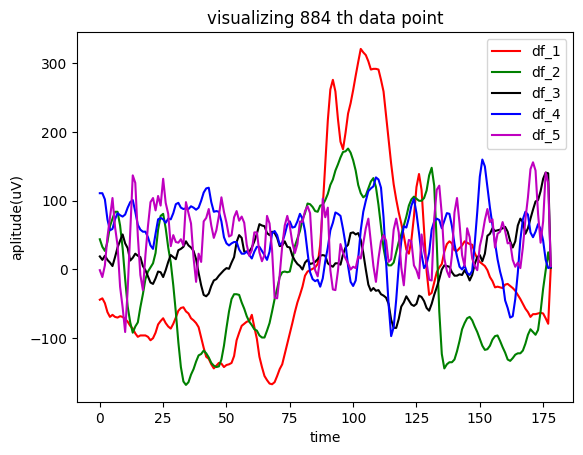

In [ ]:
### all categories
visualize_eeg(5)

## Converting data into integer and making the data into seizure and non-seizure cateogry

In [ ]:
all_data = data.copy().astype('int')

In [ ]:
all_data

array([[135, 190, 229, ..., -83, -51,   4],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   5],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   5],
       [-40, -25,  -9, ...,  59,  55,   3],
       [ 29,  41,  57, ...,   2,  20,   4]])

In [ ]:
all_data[:, -1] = np.where(all_data[:, -1] != 1, 0, all_data[:, -1])
all_data

array([[135, 190, 229, ..., -83, -51,   0],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   0],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   0],
       [-40, -25,  -9, ...,  59,  55,   0],
       [ 29,  41,  57, ...,   2,  20,   0]])

In [ ]:
print(len(all_data[all_data[:, -1] == 1]))
print(len(all_data[all_data[:, -1] == 0]))

2300
9200


## Plot functions

### function to plot loss curve of the
- (training and validation loss) and
- (training and validation accuracy)


In [ ]:
def plot_loss_accuracy(history, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(history.history['loss'], 'b-')
    ax[0].plot(history.history['val_loss'], 'r-')
    ax[0].legend(['train_loss', 'val_loss'])
    ax[0].set_title('Loss curve')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss %')

    ax[1].plot(history.history['accuracy'], 'b-')
    ax[1].plot(history.history['val_accuracy'], 'r-')
    ax[1].legend(['train_accuracy', 'val_accuracy'])
    ax[1].set_title('Accuracy curve')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('accuracy %')

    plt.suptitle(title)
    plt.savefig(title + '.png')

    plt.show()

In [ ]:
# Initialize StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

In [ ]:
def input_output_data(data, random_state=2023):

    X = all_data[:, :-1]
    y = all_data[:, -1]

    return X, y

X, y = input_output_data(data)

In [ ]:
def process_input(X, y, train_index, val_index):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = np.expand_dims(X_train, axis=2)
    X_val = np.expand_dims(X_val, axis=2)

    input_shape = (X_train.shape[1], 1)

    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')


    return X_train, X_val, y_train, y_val, input_shape

## Logger setup

In [ ]:
import absl.logging
import sys
import logging
absl.logging.set_verbosity(absl.logging.ERROR)
absl.logging.set_verbosity(absl.logging.INFO)

In [ ]:
def init_logger(log_file, log_level=logging.INFO, stdout=True):
    logger = logging.getLogger()
    logger.setLevel(log_level)

    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')

    file_handler = logging.FileHandler(log_file, mode='w')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    if stdout:
        console_handler = logging.StreamHandler(sys.stdout)
        console_handler.setFormatter(formatter)
        logger.addHandler(console_handler)

    return logger


## Let's experiment with the Residual Connection



In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 34.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# Define the Transformer model
def create_transformer_model(input_dim, hidden_dim, num_classes, num_layers, num_heads, head_size, ff_dim, dropout):
    inputs = layers.Input(shape=(None,))
    x = layers.Embedding(input_dim, hidden_dim)(inputs)
    x = PositionalEncoding(hidden_dim)(x)

    # Transformer Encoder
    for _ in range(num_layers):
        x = TransformerBlock(hidden_dim, num_heads, head_size, ff_dim, dropout)(x)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model

# Define the Positional Encoding
class PositionalEncoding(layers.Layer):
    def __init__(self, hidden_dim, max_len=200):
        super(PositionalEncoding, self).__init__()
        self.dropout = layers.Dropout(0.1)
        pe = np.zeros((max_len, hidden_dim))
        position = np.arange(0, max_len, dtype=np.float32)[:, np.newaxis]
        div_term = np.exp(np.arange(0, hidden_dim, 2).astype(np.float32) * (-np.log(10000.0) / hidden_dim))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[np.newaxis, ...]
        self.pe = tf.constant(pe, dtype=tf.float32)

    def call(self, inputs):
        inputs += self.pe[:, :tf.shape(inputs)[1], :]
        return self.dropout(inputs)

# Define the TransformerBlock
class TransformerBlock(layers.Layer):
    def __init__(self, hidden_dim, num_heads, head_size, ff_dim, dropout):
        super(TransformerBlock, self).__init__()
        self.att = tfa.layers.MultiHeadAttention(num_heads=num_heads, head_size=head_size)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(hidden_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [ ]:


# # Prepare your data
# X_train, y_train = ...  # Replace with your training data
# X_val, y_val = ...  # Replace with your validation data


# # Train the model
# history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_val, y_val))

# # After training, you can use the model to make predictions on new data


In [ ]:
# Define hyperparameters
input_dim = 100  # Replace with the actual input dimension
hidden_dim = 64
num_classes = 2
num_layers = 2
num_heads = 4
head_size = hidden_dim // num_heads
ff_dim = hidden_dim * 4
dropout = 0.1
batch_size = 32
num_epochs = 10
lr = 0.001

In [ ]:

# Perform cross-validation
fold_accuracy = []
fold = 1

for train_index, val_index in skf.split(X, y):
    X_train, X_val, y_train, y_val, input_shape = process_input(X, y, train_index, val_index)


    # Create an instance of the Transformer model
    # model = create_transformer_model(input_shape[1], hidden_dim, num_classes, num_layers, num_heads, dropout)
    model = create_transformer_model(input_shape[1], hidden_dim, num_classes, num_layers, num_heads, head_size, ff_dim, dropout)

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])

    log_file = f"model_fold_{fold}.log"
    model_name = f"model_fold_{fold}.h5"

    # Clear existing log handlers and close log files
    root_logger = logging.getLogger()
    for handler in root_logger.handlers:
        handler.close()
    root_logger.handlers.clear()

    # Create a separate log file for each model
    logger = init_logger(log_file, stdout=False)


    logger.info(f"\n\n---- fold = {fold} -------\n")
    print(f"\n\n---- fold = {fold} ------\n")

    # Define the checkpoint callback to save the best model
    checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True, mode='max', save_format="h5")

    # Train the model and capture the history
    history = model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_val, y_val), epochs=100,
                        callbacks=[checkpoint])

    # Log loss and accuracy
    for i, (loss, accuracy) in enumerate(zip(history.history['loss'], history.history['accuracy'])):
        logger.info(f"Epoch {i+1} - Loss: {loss} - Accuracy: {accuracy}")
    for i, (val_loss, val_accuracy) in enumerate(zip(history.history['val_loss'], history.history['val_accuracy'])):
        logger.info(f"Epoch {i+1} - Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}")


    # Evaluate the model on the test set
    loss_scale_optimizer, accuracy = model.evaluate(X_val, y_val)
    fold_accuracy.append(accuracy)

    # Log fold accuracy
    logger.info(f"model_Fold = {fold} accuracy: {accuracy}")

    print(f"model_Fold = {fold} accuracy: {accuracy}")
    plot_loss_accuracy(history, f"model_fold_{fold}")
    # plot_accuracy(history)

    fold += 1

# Calculate the average accuracy across all folds
mean_accuracy = np.mean(fold_accuracy)
print("Mean Accuracy:", mean_accuracy)

TypeError: ignored